## Goal:
 * Take a list of lines assuming that they are a group of sidewalks within a given street polygon
 * Clean them and return the clean versions in a list

## Cleaning strategy:
Get two lines and clean them if they have following issues:
* If they have intersection check if the length of segments before or after intersection are less than 𝚝𝚘𝚕𝙸𝚗𝚝 and if yes cut those segments. Note: do this only for the two close points (one from each line) to the intersection.
    * The intersection can be in form of a Point or LineString or MultiPoint. 
* Elif they intersect eachother after they are both extended from both side by 𝚎𝚡𝚝𝙻, find the distances of all four points from the intersection, find the two minumum distances and if both of these distances are less than 𝚝𝚘𝚕𝙸𝚗𝚝, move the corresponding two points to intersection.
    * The intersection can be in form of Point or LineString or MultiPoint.
* Else find all four distances of end points from each other, find the minumum distance, and if this minimum distance was less than 𝚝𝚘𝚕𝙲𝚕𝚘𝚜𝚎 move the corresponding two points their average point.

## Move to Avg point if 𝚝𝚘𝚕𝙲𝚕𝚘𝚜𝚎 condition is satisfied:
* Find the two close Points first and then check the $\texttt{tolClose}$ condition

In [4]:
def findTwoClosePointsIndex(twoLineList):
    # Takes two lines and gives the index of two close points (one from each line) 
    # in addition to the distance between them
    distances = []
 
    for i in range(2):
        for j in range(2):
            distances.append(Point(twoLineList[0][-i]).distance(Point(twoLineList[1][-j])))
            
    if distances.index(min(distances)) == 0:
            return [[0,0], min(distances)] 
    if distances.index(min(distances)) == 1:
            return [[0,1], min(distances)] 
    if distances.index(min(distances)) == 2:
            return [[1,0], min(distances)] 
    if distances.index(min(distances)) == 3:
            return [[1,1], min(distances)] 
        
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    # Takes two lines finds the two close points (one from each line) and 
    # Move them to their avg if the distance between them is less than 
    # tolClose
    lines = deepcopy(twoLineList)
    disAndIndex = findTwoClosePointsIndex(lines)
    if disAndIndex[1] < tolClose:
        avgX = (lines[0][-disAndIndex[0][0]][0] + lines[1][-disAndIndex[0][1]][0])/float(2)
        avgY = (lines[0][-disAndIndex[0][0]][1] + lines[1][-disAndIndex[0][1]][1])/float(2)
        lines[0][-disAndIndex[0][0]] = [avgX, avgY]
        lines[1][-disAndIndex[0][1]] = [avgX, avgY]
    return lines

## For the case in which the two line has intersection:
* If intersection is a Point:
    * Find two endpoints that are closer to the intersection
    * Check if the distance between each of those endpoints from the intersection is less than tolInt
    * For any of those two if the tolInt condition is met, move the end point to the intersection
* If intersection is a LineString: 
    * Find the midpoint of the intersection
    * Repeat the case of Point intersection but this time with midpoint as intersection point
* If intersection is a MultiPoint:
    * Repeat the case of Point intersection for each intersection point

In [2]:
def findTwoClosePointFromgivenPointIndex(twoLineList, givenPoint):
    # Takes twolines and a given point gives the index of two closes points (one from each line)
    # a given point in addition to the distance between them
    shortDisGivenIndex = []
    for i in range(2):
        distances = []
        for j in range(2):
            distances.append(Point(twoLineList[i][-j]).distance(givenPoint))
        shortDisGivenIndex.append([distances.index(min(distances)), min(distances)])
    return shortDisGivenIndex
            

def cleanIfintesectedAlready(twoLineList, tolInt):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [intrsct.x, intrsct.y]
        return lines
    
    elif intrsct.geom_type == 'LineString':
        midPoint = intrsct.interpolate(intrsct.length/2)
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, midPoint)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [midPoint.x, midPoint.y]
        return lines
    
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            for i in range(2):
                if shortDisIndices[i][1] < tolInt:
                    lines[i][-shortDisIndices[i][0]] = [intPoint.x, intPoint.y]
        return lines    

## For the case in which the extended version of the two line has intersection:
* Extend each line from both sides by some length $\texttt{extL}$ (Note: some lines can actually include multiple segments) 
* find the intersection for the extended version of lines
* If intersection is a Point: 
    * Find the two close endpoints (one from each line) if the tolInt condition was met for **both** of them move the end points to the intersection
* If intersection is a LineString:
    * Apply the $\texttt{connectToAvgIfCloseEnough}$ with $\texttt{tolInt}$ or even higher values to deal with "T-intersection gaps"
* If intersection is a MultiPoint:
    * Repeat the case of Point intersection for each intersection point

In [3]:
def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
            lines[0][-shortDisIndices[0][0]] = [intrsct.x, intrsct.y]
            lines[1][-shortDisIndices[1][0]] = [intrsct.x, intrsct.y]
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    elif intrsct.geom_type == 'LineString':
        return connectToAvgIfCloseEnough(lines, tolInt) #Not by tolClose
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Extended version of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
                lines[0][-shortDisIndices[0][0]] = [intPoint.x, intPoint.y]
                lines[1][-shortDisIndices[1][0]] = [intPoint.x, intPoint.y]
        return lines

# Work on this else i.e. the case where the extended versions meet in form
# of MultiPoints very far and connectToAvgIfCloseEnough needs to be applied     
#             else:
#                 return connectToAvgIfCloseEnough(lines, tolClose)

# Func to clean any kind of dangles between two lines:

In [4]:
def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)

## Func to clean a group of lines and not just two lines:
* each sidewalk will be compared to all others within the same polygon

In [5]:
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean

## Plotting code for visualization only:

In [6]:
import shapely 
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

## Code:

In [7]:
# Packages:
import shapely
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from copy import deepcopy
import fiona
import matplotlib
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()

# Cleaning:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point!!! Check your tolerances"
        print line
        return [0,0]
    
def findTwoClosePointsIndex(twoLineList):
    # Takes twolines and gives the index of two close points (one from each line) 
    # in addition to the distance between them
    distances = []
 
    for i in range(2):
        for j in range(2):
            distances.append(Point(twoLineList[0][-i]).distance(Point(twoLineList[1][-j])))
            
    if distances.index(min(distances)) == 0:
            return [[0,0], min(distances)] 
    if distances.index(min(distances)) == 1:
            return [[0,1], min(distances)] 
    if distances.index(min(distances)) == 2:
            return [[1,0], min(distances)] 
    if distances.index(min(distances)) == 3:
            return [[1,1], min(distances)] 
        
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lines = deepcopy(twoLineList)
    disAndIndex = findTwoClosePointsIndex(lines)
    if disAndIndex[1] < tolClose:
        avgX = (lines[0][-disAndIndex[0][0]][0] + lines[1][-disAndIndex[0][1]][0])/float(2)
        avgY = (lines[0][-disAndIndex[0][0]][1] + lines[1][-disAndIndex[0][1]][1])/float(2)
        lines[0][-disAndIndex[0][0]] = [avgX, avgY]
        lines[1][-disAndIndex[0][1]] = [avgX, avgY]
    return lines

        
def findTwoClosePointFromgivenPointIndex(twoLineList, givenPoint):
    # Takes twolines and a given point gives the index of two closes points (one from each line)
    # a given point in addition to the distance between them
    shortDisGivenIndex = []
    for i in range(2):
        distances = []
        for j in range(2):
            distances.append(Point(twoLineList[i][-j]).distance(givenPoint))
        shortDisGivenIndex.append([distances.index(min(distances)), min(distances)])
    return shortDisGivenIndex
            

def cleanIfintesectedAlready(twoLineList, tolInt):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [intrsct.x, intrsct.y]
        return lines
    
    elif intrsct.geom_type == 'LineString':
        midPoint = intrsct.interpolate(intrsct.length/2)
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, midPoint)
        for i in range(2):
            if shortDisIndices[i][1] < tolInt:
                lines[i][-shortDisIndices[i][0]] = [midPoint.x, midPoint.y]
        return lines
    
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            for i in range(2):
                if shortDisIndices[i][1] < tolInt:
                    lines[i][-shortDisIndices[i][0]] = [intPoint.x, intPoint.y]
        return lines    
def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = [line[-j][0] + extL * cosT, line[-j][1] + extL * sinT]
            extCoordsNeg = [line[-j][0] - extL * cosT, line[-j][1] - extL * sinT]
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    
    if intrsct.geom_type == 'Point':
        shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intrsct)
        if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
            lines[0][-shortDisIndices[0][0]] = [intrsct.x, intrsct.y]
            lines[1][-shortDisIndices[1][0]] = [intrsct.x, intrsct.y]
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    elif intrsct.geom_type == 'LineString':
        return connectToAvgIfCloseEnough(lines, tolInt) #Not by tolClose
    elif intrsct.geom_type == 'MultiPoint':
        print "Warning: intersection of Extended version of Following lines is a MultiPoint:"
        print lines
        for intPoint in intrsct:
            shortDisIndices = findTwoClosePointFromgivenPointIndex(lines, intPoint)
            if max(shortDisIndices[0][1], shortDisIndices[1][1]) < tolInt:
                lines[0][-shortDisIndices[0][0]] = [intPoint.x, intPoint.y]
                lines[1][-shortDisIndices[1][0]] = [intPoint.x, intPoint.y]
        return lines

# Work on this else i.e. the case where the extended versions meet in form
# of MultiPoints very far and connectToAvgIfCloseEnough needs to be applied     
#             else:
#                 return connectToAvgIfCloseEnough(lines, tolClose)
        
            

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
    
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean
# Plotting:
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

## Main code Examples:

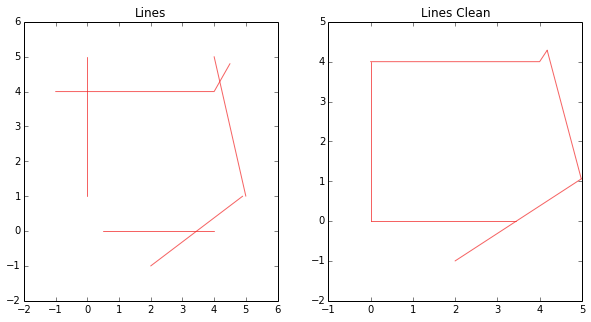

In [8]:
A, B = (0,1), (0,5)
line1 = [A, B]
A, B = (-1,4), (4,4)
line2 = [A, B,(4.5, 4.8)]
A, B = (4.9,1), (2,-1)
line3 = [A, B]
A, B = (0.5,0), (4,0)
line4 = [A, B]
line5 =[(4,5), (5,1)]
fourLineList = [line1, line2, line3, line4, line5]
extL, tolInt, tolClose = 100, 1.1, 0
fourLineListClean = cleanEachGroup(fourLineList, extL, tolInt, tolClose)
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in fourLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, fourLineList, "Lines")
ax = fig.add_subplot(122)
for line in fourLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, fourLineListClean, "Lines Clean")


[[(0, -1), (0, 15)], [(1, 2), (5, 5), (1, 15)]]


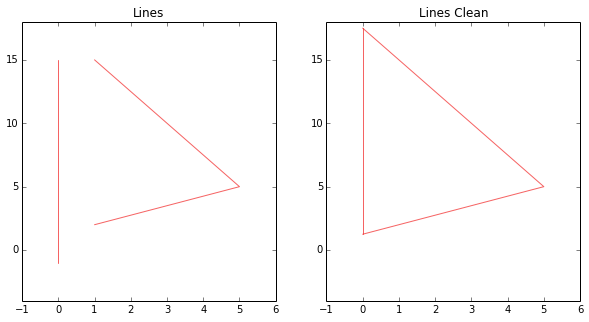

In [9]:
A, B = (0,-1), (0,15)
line1 = [A, B]
# A, B = (-1,3), (0,11)
# line2 = [A, B]
A, B = (1,2), (5,5)
line2 = [A, B, (1,15)]
twoLineList = [line1, line2]
extL, tolInt, tolClose = 100, 100, 0.5
twoLineListClean = cleanEachGroup(twoLineList, extL, tolInt, tolClose)
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in twoLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines")
ax = fig.add_subplot(122)
for line in twoLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines Clean")

[[0, 1.0869565217391308], [1, 0.6650895017729721]]
[[[-0.6521739130434785, 5.869565217391305], (3, 1)], [(5, 7), [-0.6521739130434785, 5.869565217391305]]]


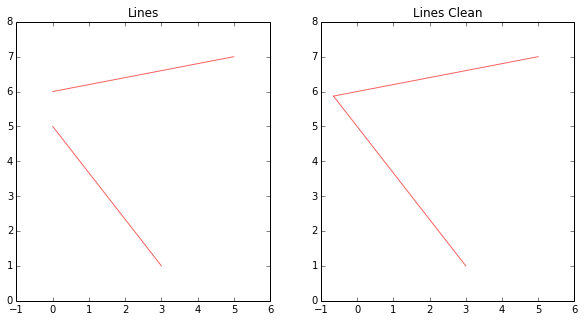

In [10]:
A, B = (0,5),(3,1)
line1 = [A, B]
# A, B = (0,3), (0,11)
# line2 = [A, B]
A, B = (5,7),(0,6)
line2 = [A, B]
twoLineList = [line1, line2]
print findTwoClosePointFromgivenPointIndex(twoLineList, Point([-0.6521739130434785, 5.869565217391305]))
extL, tolInt, tolClose = 100, 100 , 0.5
twoLineListClean = cleanEachGroup(twoLineList, extL, tolInt, tolClose)
print twoLineListClean
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in twoLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines")
ax = fig.add_subplot(122)
for line in twoLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines Clean")


[[0, 2.8830382000174617], [1, 0.6650895017729721]]
[[[2.096774193548387, 6.419354838709677], (3, 1)], [(5, 7), [2.096774193548387, 6.419354838709677]]]


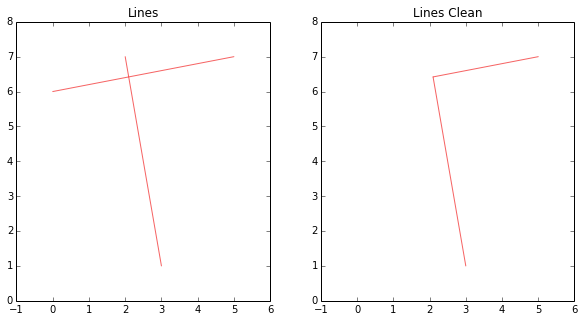

In [11]:
A, B = (2,7),(3,1)
line1 = [A, B]
# A, B = (0,3), (0,11)
# line2 = [A, B]
A, B = (5,7),(0,6)
line2 = [A, B]
twoLineList = [line1, line2]
print findTwoClosePointFromgivenPointIndex(twoLineList, Point([-0.6521739130434785, 5.869565217391305]))
extL, tolInt, tolClose = 100, 100 , 0.5
twoLineListClean = cleanEachGroup(twoLineList, extL, tolInt, tolClose)
print twoLineListClean
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in twoLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines")
ax = fig.add_subplot(122)
for line in twoLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines Clean")


POINT (0 9)
[[0, 2.2280222565772094], [0, 3.1976480014255464]]
[[(0, 8), [0.0, 9.5]], [[0.0, 9.5], (0, 14), (0, 20)]]


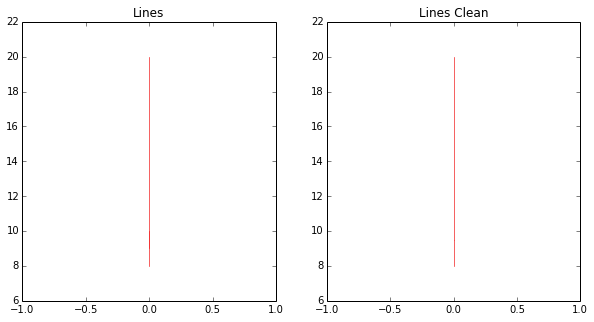

In [12]:
A, B = (0,8),(0,10)
line1 = [A, B]
A, B = (0,9), (0,14)
line2 = [A, B, (0,20)]
midPoint = LineString(line1).interpolate( LineString(line1).length/2)
print midPoint
twoLineList = [line1, line2]
print findTwoClosePointFromgivenPointIndex(twoLineList, Point([-0.6521739130434785, 5.869565217391305]))
extL, tolInt, tolClose = 100, 100 , 0.5
twoLineListClean = cleanEachGroup(twoLineList, extL, tolInt, tolClose)
print twoLineListClean
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in twoLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines")
ax = fig.add_subplot(122)
for line in twoLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines Clean")


POINT (0 9)
[[0, 2.2280222565772094], [0, 6.165027285963378]]
[[(0, 8), (0, 10)], [(0, 12), (0, 14)]]


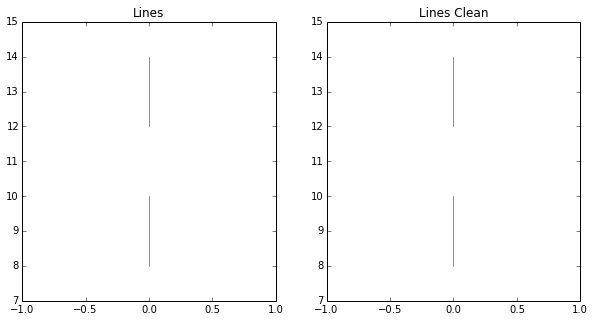

In [13]:
A, B = (0,8),(0,10)
line1 = [A, B]
A, B = (0,12), (0,14)
line2 = [A, B]
midPoint = LineString(line1).interpolate( LineString(line1).length/2)
print midPoint
twoLineList = [line1, line2]
print findTwoClosePointFromgivenPointIndex(twoLineList, Point([-0.6521739130434785, 5.869565217391305]))
extL, tolInt, tolClose = 100, 1 , 0.5
twoLineListClean = cleanEachGroup(twoLineList, extL, tolInt, tolClose)
print twoLineListClean
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in twoLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines")
ax = fig.add_subplot(122)
for line in twoLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, twoLineList, "Lines Clean")
